__Получение гиперспектральных изображений методом сканирования с дрона__

Первым шагом надо прочитать калибровочный кадр.
На кадре изображено поле, состоящее из линии, где каждая точка линии растянута по вертикали на весь доступный спектр.
Таким образом при входном отверстии в виде точки мы получаем линию спектра, при входном отверстии в виде щели (по горизонтали), мы получаем поле спектра, где каждая вертикальная линия является спектром точки, видимой через щель.

Исходим из предположения, что через щель спектрометра снят чистый белый лист бумаги, равномерно освещенный солнцем и освещение 
не изменится в течении полета. 

Первое, что надо сделать - обрезать кадр для удобной работы со спектром.
Далее надо понимать, что оптическая схема не идеальна и спектральное поле, возможно, будет наклонено, это надо учесть при выборе направления считывания. Я провел две линии, которые являются границами спектрального поля на изображении. Перебор по горизонтали всех возможных линий между этими двумя - и будет набор спектров, соответствующий набору всех видимых через щель точек.

In [177]:
#https://en.wikipedia.org/wiki/Hyperspectral_imaging
#Hyperspectral Imaging: Techniques for Spectral Detection and Classification, Том 1
#https://www.peauproductions.com/pages/calibrating-dji-camera-ndvi-red-nir-images
#solar radiation spectrum at sea level
#https://www.nature.com/articles/srep28665#f1 - спектр Canon T3i
#Матрица	1/2.3” CMOS, число эффективных пикселей:12,4 Mп (общее число пикселей: 12,76 Mп) Sony EXMOR ( IMX117CQT ?) 
#Объектив	FOV 94°, 20 мм (эквивалент формата 35 мм), f/2.8, фокус на ∞
#https://tproger.ru/translations/opencv-python-guide/

   
      #Remote Sensing Reflectance (Rrs)        
#https://oceancolor.gsfc.nasa.gov/atbd/rrs/
#Reflectance processing of remote sensing spectroradiometer data
#https://www.sciencedirect.com/science/article/pii/S0098300400000960
#Spectral reflectance is the ratio of incident-to-reflected radiant flux measured from an object or area over specified wavelengths. Unlike radiance and irradiance values, reflectance is an inherent property of an object and is independent of time, location, illumination intensity, atmospheric conditions and weather


import numpy as np
import cv2


# Для начала выбираем тот видеофайл, где снят чистый белый лист бумаги
# и выберем любой подходящий кадр, когда перед каерой лежит лист

cap = cv2.VideoCapture('D:\\Phantom-Spectro-Taman\\DJI_0001.MOV')

frame_no=6*24 # используем кадр из видео, соответствующий например 6 секунде (при 24 кадр/сек)
cap.set(1,frame_no) 
ret, frame = cap.read() # Прочесть кадр

print ("Resolution: ",frame.shape)

# Нужно определить ту область изображения, куда проецируется спектральная картина
# Далее можно будет увидеть кадр и если потребуется, подправить границы с учетом своего случая 

frameY1=50
frameY2=650
frameX1=600
frameX2=1150

img = frame[frameY1:frameY2,frameX1:frameX2] #высота:высота ширина:ширина

print ("Cropped resolution: ",img.shape)


# Теперь внутри выбранной области изображения нужно задать точные границы отображаемого спектра.
# Исходя из представления, что каждая точка формирует вертикальную спектральную линию, зададим самую крайнюю левую 
# и самую крайнюю правую линию, в пределах которой будем работать со спектром. 
# Координаты будут указаны так:

y_up=100 # Самая верхняя точка каждой спектральной линии по высоте
y_down=550 # Самая нижняя точка каждой спектральной линии по высоте

#Горизонтальные координаты указаны отдельно для верхней и нижней точки для того, чтобы можно было учесть 
#возможный наклон спектральных линий
#Конечно, на самом деле все спектральные линии находятся не на одной высоте и имеют немного отличающийся наклон из за 
#влияния геометрии используемого dvd-диска. Это должно быть учтено в будущем.

x_up_left=20 # Верхняя координата x самой левой спектральной линии
x_down_left=60 # Нижняя координата x самой левой спектральной линии

x_up_right=470 # Верхняя координата x самой правой спектральной линии
x_down_right=510 # Нижняя координата x самой правой спектральной линии

#отобразим самые крайние спектральные линии на вырезанном изображении. 
img = cv2.line(img,(x_down_left,y_down),(x_up_left,y_up),(255,0,0),1) #Левая граница
img = cv2.line(img,(x_down_right,y_down),(x_up_right,y_up),(255,0,0),1) #Правая граница

#central line
# img = cv2.line(img,(round((x_down_left+x_down_right)/2),y_down),(round((x_up_left+x_up_right)/2),y_up),(255,0,0),1) #Right border


Resolution:  (1080, 1920, 3)
Cropped resolution:  (600, 550, 3)


In [178]:
def ShowFrame ():
    cv2.imshow('Cropped frame', img) # show frame on window
    while True:
        ch = 0xFF & cv2.waitKey(1) # Wait for a second
        if ch == 27:
            break
    cap.release()
    cv2.destroyAllWindows()
    return()

ShowFrame() # Визуальная проверка работы с фреймом

()

In [180]:
cv2.imwrite('D:\\Phantom-Spectro-Taman\\output_spec.png',img)


True

На этом этапе можно проверить границы считываемого спектра с помощью ***ShowFrame()***
ESC - закрыть окно

In [119]:
# Создадим функцию для чтения среза c изображения

def GetLine (img,X1,Y1,X2,Y2,BGR):
    # Последовательное чтение ячеек вдоль линии
    LineArr=[] # Сюда будет записан список значений яркостей пикселов для одного из цветов
    #LineArr=np.array([])
    YDl=Y1-Y2 # Дельта по Y при Y1>Y2
    XDl=X1-X2 # Дельта по X при X1<X2
    for Y in range (YDl,0,-1):
        X=XDl*(Y/YDl) # Положение считываемой точки по оси X определяется пропорционально положению по оси Y
        YY=Y+Y2
        XX=int(round(X2+X))
        LineArr.append(img[YY,XX,BGR])
        #LineArr=np.append(LineArr,(img[YY,XX,BGR]))
        #img[YY,XX]=[255,255,255] #для визуальной проверки правильности считывания
    return(LineArr)


# Прочитаем один срез из середины

# Точка начала отсчета (ожидается, что спектр расположен вертикально, синий снизу, красный сверху)
X1=round((x_down_left+x_down_right)/2)
Y1=y_down

# Точка конца отсчета (Конец линии там, где заканчивается чувствительность в районе красного или ближнего инфракрасного)
X2=round((x_up_left+x_up_right)/2)
Y2=y_up


line_B=GetLine (img,X1,Y1,X2,Y2,0)  
line_G=GetLine (img,X1,Y1,X2,Y2,1)  
line_R=GetLine (img,X1,Y1,X2,Y2,2)    
    

Наша функция ***GetLine ()*** будет использоваться для чтения отдельной спектральной линии, соответствующей одной точке.

Посмотрим на график. Сейчас на горизонтальной оси находятся координаты относительно спектральной линии. Для дальнейшей работы их следует перевести в значения длинн волн. Определить соответствие яркости той или иной длинне волны для собственной получившейся оптической схемы можно используя набор фильтров с известными границами, либо калибровочные источники освещения с известными спектральными характеристиками, либо с той или иной точностью, опираясь на известные параметры чувствительности используемой в камере матрицы. 

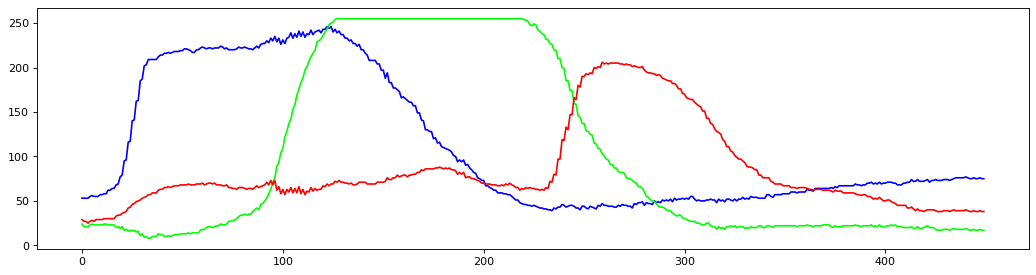

In [120]:
import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(line_B,color='blue')
plt.plot(line_G,color='#00FF00')
plt.plot(line_R,color='#FF0000')

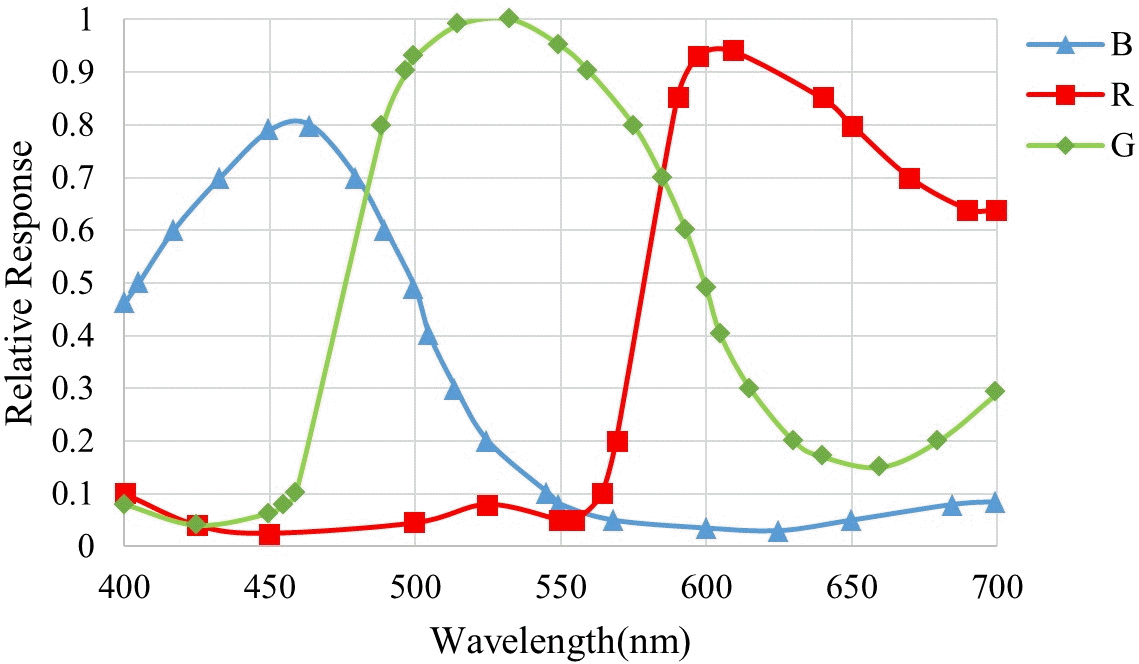
    

Приводим значения яркостей в считанной линии к яркостям для соотвествующих длинн волн ***GetSpecFromLine()***

In [121]:
def GetSpecFromLine(line,i1,i2,nm1,nm2,BGR):
    spec=[]
    Dnm=nm2-nm1
    Di=i2-i1
    for nm in range (0,Dnm,1):
        i=int(round(Di*(nm/Dnm)+i1)) # Нахождение на срезе точки пропорционально положению на спектре
        # Здесь можно вставить поправочный коэффициент в зависимости от цвета пиксела, указанного в BGR (0,1 или 2)
        # Если BGR >2, то выводить массив значений длинн волн
        if 0 <= BGR <= 2:
            spec.append(line[i])
        else:
            spec.append(nm+nm1)            
    return(spec)


#Для своего случая я указываю границы спектра от 400нм до 700нм
nm1=400
nm2=700

#И соответствующие им границы в пикселах на линии, получающейся при вызове функции чтения линии GetLine()
i1=20 #Начало спектра на линии среза (соответствует длинне волны nm1)
i2=350 #Конец спектра на линии среза (соответствует nm2)


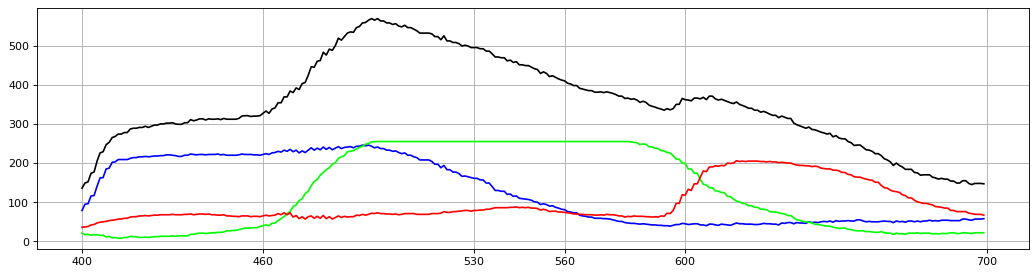

In [122]:
spec_Bnm=GetSpecFromLine(line_B,i1,i2,nm1,nm2,0)
spec_Gnm=GetSpecFromLine(line_G,i1,i2,nm1,nm2,1)
spec_Rnm=GetSpecFromLine(line_R,i1,i2,nm1,nm2,2)
spec_nm =GetSpecFromLine(line_B,i1,i2,nm1,nm2,99) # массив длинн волн 
spec_Anm=0.0+np.array(spec_Bnm)+np.array(spec_Gnm)+np.array(spec_Rnm) # суммарный спектр
        
fig = plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

plt.plot(spec_nm,spec_Bnm,color='blue')
plt.plot(spec_nm,spec_Gnm,color='#00FF00')
plt.plot(spec_nm,spec_Rnm,color='#FF0000')
plt.plot(spec_nm,spec_Anm,color='#000000')

plt.xticks([400,460,530,560,600,700])
plt.grid(True)

Обработка всех линий из одного кадра
---

In [123]:
# Перебираем весь набор линий, заданный границами, которые мы указали выше
Ybottom=y_down # нижний край спектров, откуда начинается считывание синей части 
Ytop=y_up # верхний край
Xleft=x_down_left # начало первого спектра
Xright=x_down_right # начало последнего спектра
YD=Ybottom-Ytop # Количество пиксел в срезе
XD=Xright-Xleft # Количество срезов

# Наклон всех спектров, означает смещение конца (красной стороны) спектра по оси X относительно начала спектра
XtopOffset=x_up_left-x_down_left # Соответствует значению DX=X1-X2 для тестового среза выше

def ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,BGR):
    #YD=Ybottom-Ytop # Количество пиксел в срезе
    #XD=Xright-Xleft # Количество срезов
    Arrlines=np.zeros((XD,YD), dtype=int)
    
    # Перебираем все срезы в кадре
    for X in range (0,XD,1):
        Arrlines[X]=GetLine(img,Xleft+X,Ybottom,Xleft+XtopOffset+X,Ytop,BGR)
        
    Arrspecs=np.zeros((XD,nm2-nm1), dtype=int)
    for X in range (0,XD,1):
        Arrspecs[X]=GetSpecFromLine(Arrlines[X],i1,i2,nm1,nm2,0)
        
    return (Arrspecs)

Таким образом ***ArrayOfSpectres()*** будет расчитывать весь набор яркостей пиксел для одного кадра. Важно, что получить их можно раздельно для синего, зеленого и красного чувствительных элементов матрицы. Это можно использовать в последствии, А пока мы будем работать с суммой яркостей сразу во всех трех каналах для любого участка спектра.

In [124]:
#Создадим пустой массив размером с количество срезов (XD), помноженное на количество значений длинн волн (nm2-nm1)
# и запишем в него все значения спектров из кадра, в котором присутствует белый "калибровочный" лист:

Arrspecs_White1=np.zeros((XD,nm2-nm1), np.uint8)


capW = cv2.VideoCapture('D:\\Phantom-Spectro-Taman\\DJI_0001.MOV') # Видео с калибровочным листом

frame_no=6*24 # используем кадр из видео, соответствующий например 6 секунде (при 24 кадр/сек)
capW.set(1,frame_no)
ret, frame = capW.read() # Прочесть кадр
img = frame[frameY1:frameY2,frameX1:frameX2]
Arrspecs_White1=ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,0)+ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,1)+ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,2)

#И сделаем это еще 2 раза для двух дополнительных кадров (+1 сек и +2 сек) и осредним, чтобы уменьшить влияние шума.
Arrspecs_White2=np.zeros((XD,nm2-nm1), np.uint8)
Arrspecs_White3=np.zeros((XD,nm2-nm1), np.uint8)

capW.set(1,frame_no+24)
ret, frame = capW.read() # Прочесть кадр
img = frame[frameY1:frameY2,frameX1:frameX2]
Arrspecs_White2=ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,0)+ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,1)+ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,2)

capW.set(1,frame_no+48)
ret, frame = capW.read() # Прочесть кадр
img = frame[frameY1:frameY2,frameX1:frameX2]
Arrspecs_White3=ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,0)+ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,1)+ArrayOfSpectres (img,Ybottom,Ytop,Xleft,Xright,2)

Arrspecs_White=np.zeros((XD,nm2-nm1), np.uint8)

# Осредняем массивы спектров из трех кадров
Arrspecs_White=(Arrspecs_White1+Arrspecs_White2+Arrspecs_White3)/3





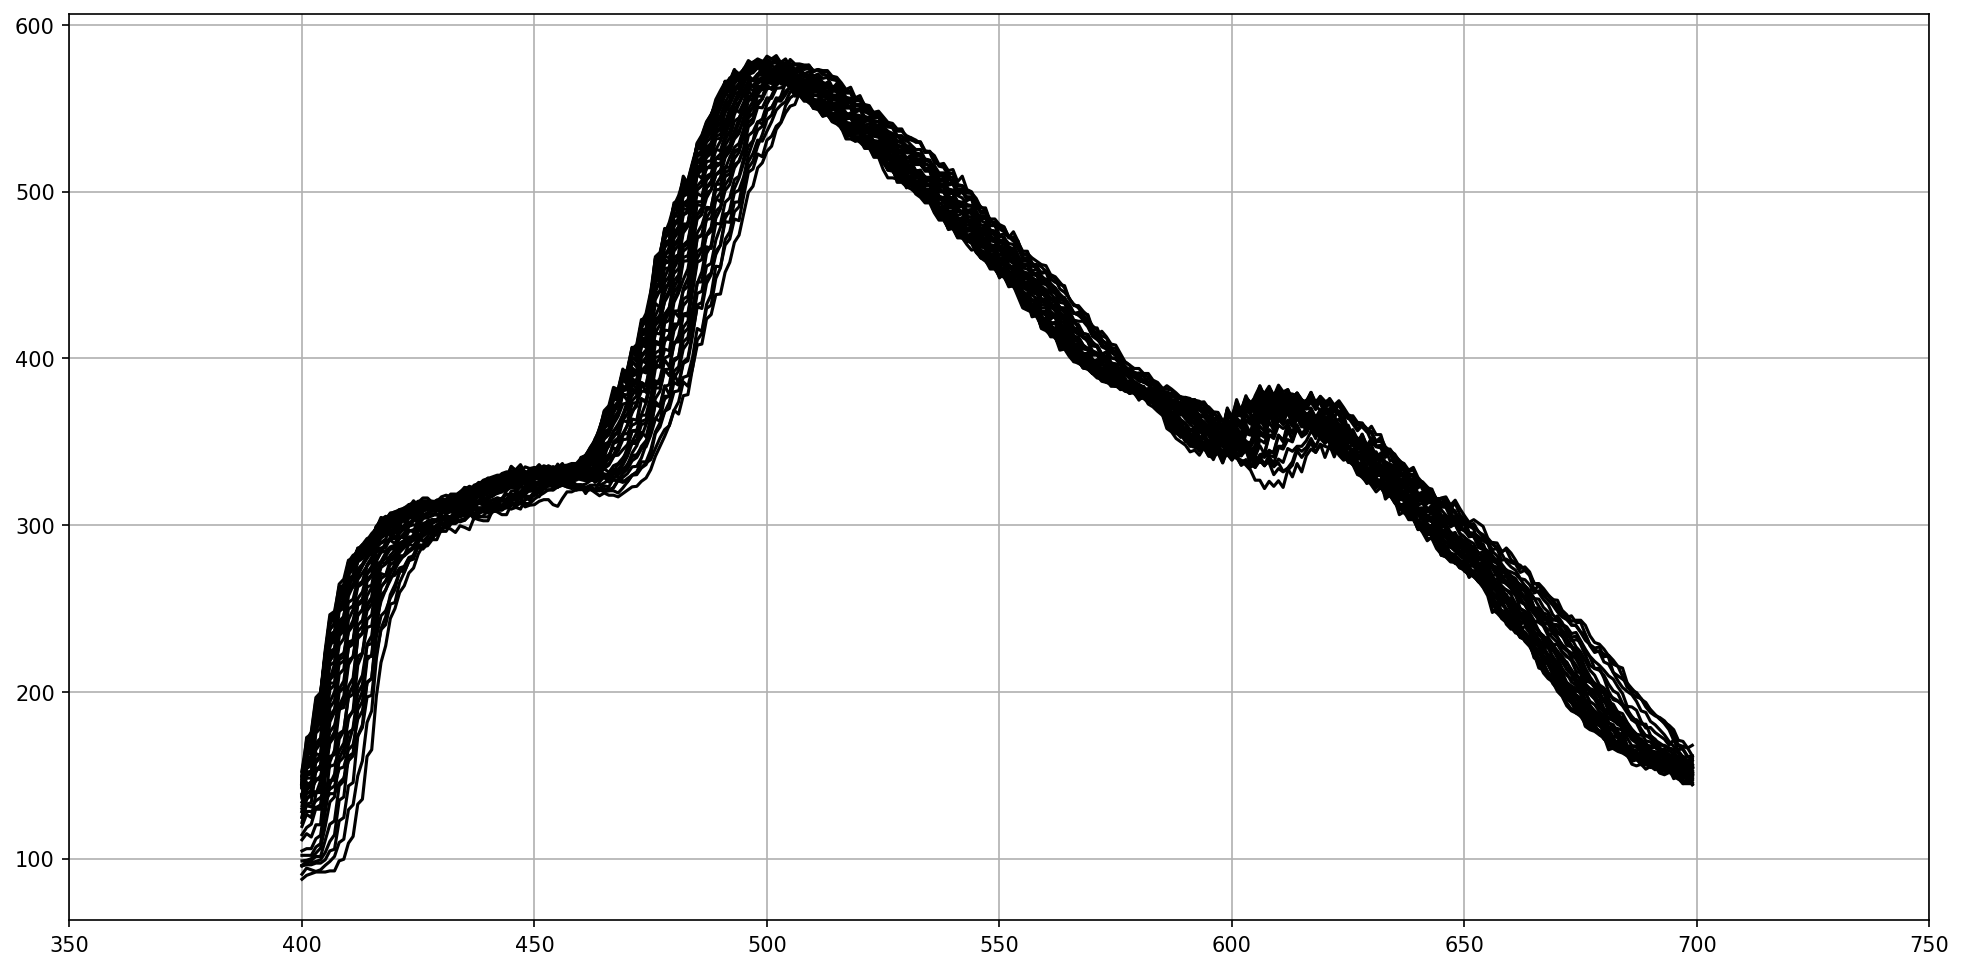

In [125]:
fig = plt.figure(num=None, figsize=(16, 8), dpi=150, facecolor='w', edgecolor='k')    
for X in range (0,XD,10):
    plt.plot(spec_nm,Arrspecs_White[X],color='black')    
plt.xticks([350,400,450,500,550,600,650,700,750])
plt.grid(True)

Набор спектров ***Arrspecs_White[]*** можно считать максимальной полученной яркостью. Все последующие значения яркостей длин волн будут показываться в пересчете на доли от соотвествующих значений в этих спектрах. Получилось, с позволения сказать, подобие некоей калибровки.
     

Начинаем работу с видео, из которого будем собирать гиперспектральный кадр
---

In [126]:
cap2 = cv2.VideoCapture('D:\\Phantom-Spectro-Taman\\DJI_0002.MOV')
#Для DJI_002 - 5 минут 24 секунд 24 кадров/сек 324*24= примерно 7776 кадров


# Получение массива спектров для точек линии, зашифрованных в кадре. Результат в долях яркости относительно белого листа от 0 до 1
def FrameGetRRS (frame2):
    img = frame2[frameY1:frameY2,frameX1:frameX2]

    Arrspecs_All=np.zeros((XD,nm2-nm1), np.uint8)
    Arrspecs_RRS=np.zeros((XD,nm2-nm1), dtype=float)

    Arrspecs_All=ArrayOfSpectres(img,Ybottom,Ytop,Xleft,Xright,0)+ArrayOfSpectres(img,Ybottom,Ytop,Xleft,Xright,1)+ArrayOfSpectres(img,Ybottom,Ytop,Xleft,Xright,2)    
    Arrspecs_RRS=Arrspecs_All/Arrspecs_White
    return (Arrspecs_RRS)


Функция ***FrameGetRRS()*** получает кадр и возвращает значения яркостей для всех спектров в кадре в долях относительно спектров белого листа, распознанного с учетом спектральной чувствительности используемой матрицы

In [172]:
#frame 7400 	Time: 5945.437906
from time import time
t0 = time()
Arrspecs_RRS=[]
Counter=0

#start_frame=180*24 # с какой секунды начнем
#start_frame=2000 # с какой секунды начнем
start_frame=100
cap2.set(1,start_frame)

while(cap2.isOpened()) and (Counter<7700): 
    ret, frame2 = cap2.read() # Read the frame
    if ret==True:
        Arrspecs_RRS.append (FrameGetRRS(frame2))
    else:
        break
    Counter+=1
    if Counter % 50 == 0:
        print ('frame %i \tTime: %f' %(Counter,time()-t0))
    #ret, frame2 = cap2.read()
    #ret, frame2 = cap2.read()
    #ret, frame2 = cap2.read() # Для длинных видео читаем каждый четвертый кадр (три в пустую), для уменьшения обработки

frame 50 	Time: 40.908818
frame 100 	Time: 82.152855
frame 150 	Time: 123.568791
frame 200 	Time: 164.443642
frame 250 	Time: 203.955225
frame 300 	Time: 243.893171
frame 350 	Time: 284.112028
frame 400 	Time: 323.489448
frame 450 	Time: 363.352057
frame 500 	Time: 403.331419
frame 550 	Time: 442.698238
frame 600 	Time: 483.420697
frame 650 	Time: 522.987326
frame 700 	Time: 562.672452
frame 750 	Time: 602.986646
frame 800 	Time: 643.650248
frame 850 	Time: 685.940289
frame 900 	Time: 726.190969
frame 950 	Time: 767.571145
frame 1000 	Time: 809.325346
frame 1050 	Time: 849.285151
frame 1100 	Time: 889.350527
frame 1150 	Time: 929.586416
frame 1200 	Time: 970.721496
frame 1250 	Time: 1012.161706
frame 1300 	Time: 1052.659756
frame 1350 	Time: 1093.569761
frame 1400 	Time: 1132.970892
frame 1450 	Time: 1172.799604
frame 1500 	Time: 1213.467755
frame 1550 	Time: 1253.096084
frame 1600 	Time: 1293.459436
frame 1650 	Time: 1333.427424
frame 1700 	Time: 1373.064725
frame 1750 	Time: 1412.696

In [130]:
print (len(Arrspecs_RRS))

100


___Теперь синтезируем цветное изображение поверхности, взяв 3 узких канала в районе максимумов чувствительности красного зеленого и синего___

Для используемой оптической схемы лучи, формирующие красную часть спектра вверху и прошедшие через входную щель спектрометра, были отражены от поверхности чуть ранее по ходу сканирования. А лучи, формирующие нижнюю, синюю часть спектра и прошедшие через входную щель, были излучены другой частью поверхности, более дальней по ходу сканирования. Поэтому чтобы избежать эффекта, напоминающего хроматическую оберацию, следует учитывать смещение строк для соответствующих длин волн и высоты. Либо использовать любую контрастную линию, на которой хорошо будет видно смещение для подбора правильных параметров.

In [173]:



gsimg = np.zeros((len(Arrspecs_RRS)+1,XD,3), np.uint8)


NmBlue=460-nm1
NmGreen=550-nm1
NmRed=630-nm1
# вычитать значение левой границы хранящихся спектров нужно потому, что в массиве они нумеруются от нуля


#будем читать от строки+10 и до конца-10, чтобы наши смещения не выходили за пределы массива с краев
for GSY in range (0+5,len(Arrspecs_RRS)-5,1):
    for GSX in range (0,XD,1):
        RRS4Blue =int(round(Arrspecs_RRS[GSY-5][GSX][NmBlue]*255.0))
        RRS4Green=int(round(Arrspecs_RRS[GSY][GSX][NmGreen]*255.0))
        RRS4Red  =int(round(Arrspecs_RRS[GSY+5][GSX][NmRed]*255.0))
        if (RRS4Green>255):
            RRS4Green=255
        if (RRS4Blue>255):
            RRS4Blue=255   
        if (RRS4Red>255):
            RRS4Red=255   
        gsimg[(len(Arrspecs_RRS))-GSY,GSX]=[RRS4Blue,RRS4Green,RRS4Red]
        #gsimg[(len(Arrspecs_RRS))-GSY,GSX]=[0,RRS4Green,0]
        #gsimg[(len(Arrspecs_RRS))-GSY,GSX]=[0,0,RRS4Red]

print ("Blue  channel: ",spec_nm[NmBlue])
print ("Green channel: ",spec_nm[NmGreen])
print ("Red   channel: ",spec_nm[NmRed])


#cv2.waitKey()

Blue  channel:  460
Green channel:  550
Red   channel:  630


In [174]:
cv2.imshow("output",gsimg)

while True:
    ch = 0xFF & cv2.waitKey(1) # Wait for a second
    if ch == 27:
        break
cap.release()
cv2.destroyAllWindows()

In [175]:
#cv2.imwrite('D:\\Phantom-Spectro\\HiperSpectral-EJI0004-B440-G540-R615.png',gsimg)
#cv2.imwrite('D:\\Phantom-Spectro\\HiperSpectral-DJI0056-R600.png',gsimg)
#cv2.imwrite('D:\\Phantom-Spectro\\HiperSpectral-008window-DJI002-B470-G530-R630.png',gsimg)


cv2.imwrite('D:\\Phantom-Spectro-Taman\\output_008_all.png',gsimg)


True